<a href="https://www.kaggle.com/code/sravanneeli/convert-train-data-to-pckl-file?scriptVersionId=97076420" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
import dask.dataframe as dd
import gc
import tensorflow as tf
print(tf.__version__)

2.6.4


In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
train_df = pd.read_csv('../input/amex-default-prediction/train_data.csv', nrows=10)
train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv',)
test_df = pd.read_csv('../input/amex-default-prediction/test_data.csv', nrows=10)

In [5]:
train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.93847,0.00173,0.00872,1.00684,0.00923,0.12404,0.00877,0.00471,NaN,NaN,0.00063,0.08099,0.70891,0.17060,0.00620,0.35859,0.52535,0.25574,NaN,0.06390,0.05942,0.00647,0.14870,1.33586,0.00821,0.00142,0.20733,0.73646,0.09622,NaN,0.02338,0.00277,0.00832,1.00152,0.00830,0.16134,0.14827,0.92300,0.35460,0.15203,0.11808,0.00188,0.15861,0.06573,0.01838,0.06365,0.19962,0.30823,0.01636,0.40162,0.09107,CR,O,0.00713,0.00767,NaN,0.65298,0.00852,NaN,0.00473,6.00000,0.27201,0.00836,0.51522,0.00264,0.00901,0.00481,0.00834,0.11940,0.00480,0.10827,0.05088,NaN,0.00755,0.08042,0.06907,NaN,0.00433,0.00756,NaN,0.00773,0.00027,0.00158,0.00424,0.00143,NaN,0.00227,0.00406,0.00712,0.00246,0.00231,0.00353,0.50661,0.00803,1.00982,0.08468,0.00382,0.00704,0.00044,0.00645,0.00083,0.00505,NaN,0.00000,0.00572,0.00708,NaN,0.00020,0.00891,NaN,1,0.00254,0.00518,0.00663,0.00971,0.00778,0.00245,1.00110,0.00267,0.00748,0.00689,1.50367,1.00613,0.00357,0.00887,0.00395,0.00365,0.00495,0.89409,0.13556,0.91119,0.97454,0.00124,0.76669,1.00869,1.00459,0.89373,NaN,0.67004,0.00997,0.00457,NaN,1.00895,2.00000,NaN,0.00433,NaN,NaN,NaN,1.00734,0.21006,0.67692,0.00787,1.00000,0.23825,0.00000,4.00000,0.23212,0.23627,0.00000,0.70228,0.43434,0.00306,0.68652,0.00874,1.00000,1.00332,1.00782,1.00008,0.00680,NaN,0.00205,0.00597,NaN,0.00435,0.00153,NaN,NaN,NaN,NaN,NaN,0.00243,0.00371,0.00382,NaN,0.00057,0.00061,0.00267
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.93666,0.00578,0.00492,1.00065,0.00615,0.12675,0.00080,0.00271,NaN,NaN,0.00253,0.06942,0.71279,0.11324,0.00621,0.35363,0.52131,0.22333,NaN,0.06526,0.05774,0.00161,0.14972,1.33979,0.00837,0.00198,0.20278,0.72089,0.09980,NaN,0.03060,0.00275,0.00248,1.00903,0.00514,0.14095,0.14353,0.91941,0.32676,0.15620,0.11874,0.00161,0.14846,0.09394,0.01303,0.06550,0.15139,0.26503,0.01769,0.40633,0.08680,CR,O,0.00241,0.00715,NaN,0.64709,0.00224,NaN,0.00388,6.00000,0.18897,0.00403,0.50905,0.00419,0.00784,0.00128,0.00652,0.14061,0.00009,0.10102,0.04047,NaN,0.00483,0.08141,0.07417,NaN,0.00420,0.00530,NaN,0.00186,0.00098,0.00990,0.00760,0.00051,NaN,0.00981,0.00013,0.00597,0.00040,0.00133,0.00777,0.50086,0.00076,1.00946,0.08184,0.00035,0.00779,0.00431,0.00233,0.00947,0.00375,NaN,0.00000,0.00758,0.00668,NaN,0.00114,0.00591,NaN,1,0.00843,0.00898,0.00185,0.00992,0.00599,0.00225,1.00678,0.00251,0.00683,0.00284,1.50358,1.00579,0.00057,0.00039,0.00835,0.00885,0.00318,0.90214,0.13633,0.91988,0.97562,0.00456,0.78601,1.00008,1.00412,0.90684,NaN,0.66865,0.00392,0.00465,NaN,1.00321,2.00000,NaN,0.00871,NaN,NaN,NaN,1.00765,0.18409,0.82228,0.00344,1.00000,0.24722,0.00000,4.00000,0.24353,0.24188,0.00000,0.70702,0.43050,0.00131,0.68641,0.00076,1.00000,1.00839,1.00433,1.00834,0.00441,NaN,0.00103,0.00484,NaN,0.00749,0.00493,NaN,NaN,NaN,NaN,NaN,0.00395,0.00317,0.00503,NaN,0.00958,0.00549,0.00922
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.95418,0.09151,0.02165,1.00967,0.00682,0.12398,0.00760,0.00942,NaN,NaN,0.00760

In [6]:
dtypes_df = train_df.dtypes.to_frame().reset_index()

# Convert `float64` --> `float16` and category cols to `int8` and str types to decrease ram use usage

In [7]:
dtype_dict = {}

In [8]:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for col in cat_cols:
    if train_df[col].dtype == "float64":
        dtype_dict[col] = "int8" # category to 
    else:
        dtype_dict[col] = str
    

In [9]:
for col in train_df.columns:
    
    if train_df[col].dtype == "float64":
        dtype_dict[col] = "float16"
    
        

# Load whole data with predefined data types

In [10]:
train_df = pd.read_csv('../input/amex-default-prediction/train_data.csv', dtype=dtype_dict)

In [11]:
gc.collect()

43

In [12]:
train_df['S_2'] = pd.to_datetime(train_df['S_2'])

In [13]:
gc.collect()

42

In [14]:
num_cols = []
for col in train_df.columns:
    if col != "S_2" and col not in cat_cols:
        num_cols.append(col)

# Lets see target variable distribution

In [15]:
train_labels['customer_ID'] = train_labels['customer_ID'].astype(str)
train_labels['target'] = train_labels['target'].astype("int8") # to decrease ram usage

In [16]:
train_labels['customer_ID'].nunique()

458913

In [17]:
gc.collect()

84

<AxesSubplot:>

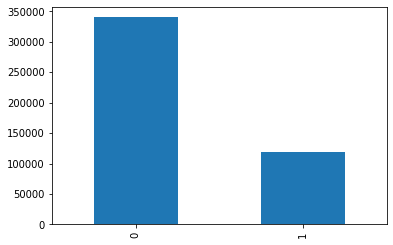

In [18]:
train_labels.target.value_counts().plot(kind='bar')

# Unique Customers

In [19]:
train_df.customer_ID.nunique() # same as labels df

458913

# Lets Aggregate Numerical columns for each customer

In [20]:
num_cols_grp_df = train_df.groupby('customer_ID')[num_cols].agg(['mean', 'std', 'min', 'max'])

In [21]:
num_cols_grp_df.columns = num_cols_grp_df.columns.to_flat_index()
num_cols_grp_df = num_cols_grp_df.reset_index()
new_num_cols = ['customer_ID']
for col in num_cols_grp_df.columns[1:]:
    new_num_cols.append("_".join(col))
num_cols_grp_df.columns = new_num_cols
gc.collect()

21

In [22]:
num_cols_grp_df['customer_ID'] = num_cols_grp_df['customer_ID'].astype(str)

In [23]:
num_cols_grp_df.head()

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,D_39_mean,D_39_std,D_39_min,D_39_max,B_1_mean,B_1_std,B_1_min,B_1_max,B_2_mean,B_2_std,B_2_min,B_2_max,R_1_mean,R_1_std,R_1_min,R_1_max,S_3_mean,S_3_std,S_3_min,S_3_max,D_41_mean,D_41_std,D_41_min,D_41_max,B_3_mean,B_3_std,B_3_min,B_3_max,D_42_mean,D_42_std,D_42_min,D_42_max,D_43_mean,D_43_std,D_43_min,D_43_max,D_44_mean,D_44_std,D_44_min,D_44_max,B_4_mean,B_4_std,B_4_min,B_4_max,D_45_mean,D_45_std,D_45_min,D_45_max,B_5_mean,B_5_std,B_5_min,B_5_max,R_2_mean,R_2_std,R_2_min,R_2_max,D_46_mean,D_46_std,D_46_min,D_46_max,D_47_mean,D_47_std,D_47_min,D_47_max,D_48_mean,D_48_std,D_48_min,D_48_max,D_49_mean,D_49_std,D_49_min,D_49_max,B_6_mean,B_6_std,B_6_min,B_6_max,B_7_mean,B_7_std,B_7_min,B_7_max,B_8_mean,B_8_std,B_8_min,B_8_max,D_50_mean,D_50_std,D_50_min,D_50_max,D_51_mean,D_51_std,D_51_min,D_51_max,B_9_mean,B_9_std,B_9_min,B_9_max,R_3_mean,R_3_std,R_3_min,R_3_max,D_52_mean,D_52_std,D_52_min,D_52_max,P_3_mean,P_3_std,P_3_min,P_3_max,B_10_mean,B_10_std,B_10_min,B_10_max,D_53_mean,D_53_std,D_53_min,D_53_max,S_5_mean,S_5_std,S_5_min,S_5_max,B_11_mean,B_11_std,B_11_min,B_11_max,S_6_mean,S_6_std,S_6_min,S_6_max,D_54_mean,D_54_std,D_54_min,D_54_max,R_4_mean,R_4_std,R_4_min,R_4_max,S_7_mean,S_7_std,S_7_min,S_7_max,B_12_mean,B_12_std,B_12_min,B_12_max,S_8_mean,S_8_std,S_8_min,S_8_max,D_55_mean,D_55_std,D_55_min,D_55_max,D_56_mean,D_56_std,D_56_min,D_56_max,B_13_mean,B_13_std,B_13_min,B_13_max,R_5_mean,R_5_std,R_5_min,R_5_max,D_58_mean,D_58_std,D_58_min,D_58_max,S_9_mean,S_9_std,S_9_min,S_9_max,B_14_mean,B_14_std,B_14_min,B_14_max,D_59_mean,D_59_std,D_59_min,D_59_max,D_60_mean,D_60_std,D_60_min,D_60_max,D_61_mean,D_61_std,D_61_min,D_61_max,B_15_mean,B_15_std,B_15_min,B_15_max,S_11_mean,S_11_std,S_11_min,S_11_max,D_62_mean,D_62_std,D_62_min,D_62_max,D_65_mean,D_65_std,D_65_min,D_65_max,B_16_mean,B_16_std,B_16_min,B_16_max,B_17_mean,B_17_std,B_17_min,B_17_max,B_18_mean,B_18_std,B_18_min,B_18_max,B_19_mean,B_19_std,B_19_min,B_19_max,B_20_mean,B_20_std,B_20_min,B_20_max,S_12_mean,S_12_std,S_12_min,S_12_max,R_6_mean,R_6_std,R_6_min,R_6_max,S_13_mean,S_13_std,S_13_min,S_13_max,B_21_mean,B_21_std,B_21_min,B_21_max,D_69_mean,D_69_std,D_69_min,D_69_max,B_22_mean,...,R_22_min,R_22_max,R_23_mean,R_23_std,R_23_min,R_23_max,D_91_mean,D_91_std,D_91_min,D_91_max,D_92_mean,D_92_std,D_92_min,D_92_max,D_93_mean,D_93_std,D_93_min,D_93_max,D_94_mean,D_94_std,D_94_min,D_94_max,R_24_mean,R_24_std,R_24_min,R_24_max,R_25_mean,R_25_std,R_25_min,R_25_max,D_96_mean,D_96_std,D_96_min,D_96_max,S_22_mean,S_22_std,S_22_min,S_22_max,S_23_mean,S_23_std,S_23_min,S_23_max,S_24_mean,S_24_std,S_24_min,S_24_max,S_25_mean,S_25_std,S_25_min,S_25_max,S_26_mean,S_26_std,S_26_min,S_26_max,D_102_mean,D_102_std,D_102_min,D_102_max,D_103_mean,D_103_std,D_103_min,D_103_max,D_104_mean,D_104_std,D_104_min,D_104_max,D_105_mean,D_105_std,D_105_min,D_105_max,D_106_mean,D_106_std,D_106_min,D_106_max,D_107_mean,D_107_std,D_107_min,D_107_max,B_36_mean,B_36_std,B_36_min,B_36_max,B_37_mean,B_37_std,B_37_min,B_37_max,R_26_mean,R_26_std,R_26_min,R_26_max,R_27_mean,R_27_std,R_27_min,R_27_max,D_108_mean,D_108_std,D_108_min,D_108_max,D_109_mean,D_109_std,D_109_min,D_109_max,D_110_mean,D_110_std,D_110_min,D_110_max,D_111_mean,D_111_std,D_111_min,D_111_max,B_39_mean,B_39_std,B_39_min,B_39_max,D_112_mean,D_112_std,D_112_min,D_112_max,B_40_mean,B_40_std,B_40_min,B_40_max,S_27_mean,S_27_std,S_27_min,S_27_max,D_113_mean,D_113_std,D_113_min,D_113_max,D_115_mean,D_115_std,D_115_min,D_115_max,D_118_mean,D_118_std,D_118_min,D_118_max,D_119_mean,D_119_std,D_119_min,D_119_max,D_121_mean,D_121_std,D_121_min,D_121_max,D_122_mean,D_122_std,D_122_min,D_122_max,D_123_mean,D_123_std,D_123_min,D_123_max,D_124_mean,D_124_std,D_124_min,D_124_max,D_125_mean,D_125_std,D_125_min,D_125_max,D_127_mean,D_127_std,D_127_min,D_127_max,D_128_mean,D_128_std,D_128_min,D_128_max,D_129_mean,D_129_std,D_129_min,D_129_max,B_41_mean,B_41_std,B_41_min,B_41_max,B_42_mean,B_42_std,B_42_min,B_42_

In [24]:
cat_cols_grp_df = train_df.groupby('customer_ID')[cat_cols].agg(['count', 'last', 'nunique'])

In [25]:
cat_cols_grp_df.columns = cat_cols_grp_df.columns.to_flat_index()
cat_cols_grp_df = cat_cols_grp_df.reset_index()
new_cat_cols = ['customer_ID']
for col in cat_cols_grp_df.columns[1:]:
    new_cat_cols.append("_".join(col))
cat_cols_grp_df.columns = new_cat_cols
gc.collect()

21

In [26]:
cat_cols_grp_df.head()

,customer_ID,B_30_count,B_30_last,B_30_nunique,B_38_count,B_38_last,B_38_nunique,D_114_count,D_114_last,D_114_nunique,D_116_count,D_116_last,D_116_nunique,D_117_count,D_117_last,D_117_nunique,D_120_count,D_120_last,D_120_nunique,D_126_count,D_126_last,D_126_nunique,D_63_count,D_63_last,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13,0.00000,1,13,2.00000,1,13,1.00000,1,13,0.00000,1,13,4.00000,1,13,0.00000,1,13,1.00000,1,13,CR,1,13,O,1,0,NaN,0,13,6.00000,1
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,13,0.00000,1,13,2.00000,1,13,1.00000,1,13,0.00000,1,13,-1.00000,1,13,0.00000,2,13,1.00000,1,13,CO,1,13,O,1,0,NaN,0,13,6.00000,1
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,13,0.00000,1,13,1.00000,1,13,1.00000,2,13,0.00000,1,13,-1.00000,1,13,0.00000,1,13,1.00000,1,13,CO,1,13,R,1,0,NaN,0,13,6.00000,1
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,13,0.00000,1,13,2.00000,1,13,1.00000,1,13,0.00000,1,13,6.00000,2,13,0.00000,1,13,1.00000,1,13,CO,1,13,O,1,0,NaN,0,13,3.00000,3
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,13,0.00000,1,13,1.00000,2,13,1.00000,1,13,0.00000,1,13,4.00000,1,13,0.00000,1,13,1.00000,1,13,CO,1,13,O,1,13,1.00000,1,13,6.00000,1


In [27]:
for col in cat_cols_grp_df.columns:
    if col == "customer_ID":
        cat_cols_grp_df[col] = cat_cols_grp_df[col].astype(str)
    if cat_cols_grp_df[col].dtype == "int64":
        cat_cols_grp_df[col] = cat_cols_grp_df[col].astype("int8")

In [28]:
num_cols_grp_df.shape, cat_cols_grp_df.shape, train_labels.shape

((458913, 709), (458913, 34), (458913, 2))

In [29]:
num_cols_grp_df = num_cols_grp_df.sort_values(by='customer_ID')
cat_cols_grp_df = cat_cols_grp_df.sort_values(by='customer_ID')
train_labels = train_labels.sort_values(by='customer_ID')

In [30]:
final_df = pd.concat([cat_cols_grp_df, num_cols_grp_df.drop(['customer_ID'], axis=1), train_labels.drop(['customer_ID'], axis=1)], axis=1)

In [31]:
(num_cols_grp_df.isna().sum(axis=0).sort_values(ascending=False) > 450000).sum()

29

* There are 29 columns which have  more than 450000 null values

In [32]:
final_df.to_pickle("./train_agg.pkl", compression="gzip")